<a href="https://colab.research.google.com/github/hotekagi/gc_assignment/blob/main/I3_TextureSynthesis/I3_TextureSynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Texture optimization for example-based synthesis

Vivek Kwatra, Irfan Essa, Aaron Bobick, and Nipun Kwatra. 2005.
Texture optimization for example-based synthesis. ACM Trans. Graph. 24, 3 (July 2005), 795–802.
https://doi.org/10.1145/1073204.1073263

Copyright © 2005 by the Association for Computing Machinery, Inc

```
This is a Python implementation of Algorithms in the paper above.
Code is my own work, but the idea is from the paper.
```

## Algorithm 1

Saving 161.jpg to 161 (4).jpg


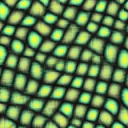

  0%|          | 0/50 [00:00<?, ?it/s]

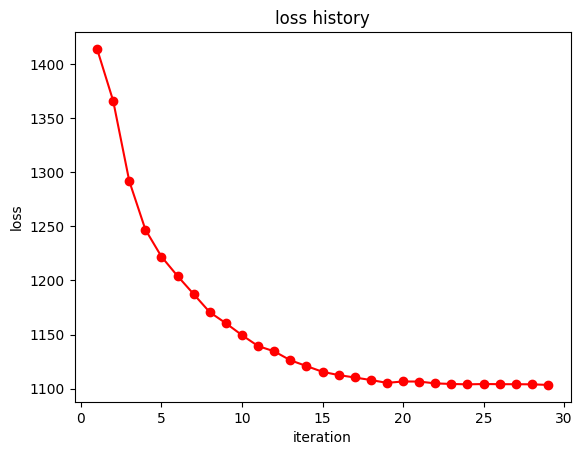

In [5]:
#@markdown **セルを実行して，textureの元画像をアップロードすると処理が始まる**
#@markdown  \\
#@markdown 処理の途中の画像の変化やプログレスバーも表示する
#@markdown  \\
#@markdown  デモの画像は
#@markdown https://github.com/1iyiwei/texture/blob/master/data/161.jpg
#@markdown より


from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image
from tqdm.notebook import tqdm

from google.colab import files
uploaded = files.upload()

### variables
#@markdown **パラメータを設定する**

#@markdown 生成する画像の1辺のサイズ
target_width = 128 #@param {type: "integer"}
#@markdown 近傍のサイズ
neighbor_width = 16 #@param {type: "integer"}
#@markdown 最大反復回数
max_iter = 50 #@param {type: "integer"}
#@markdown　実行時にlossの詳細を表示
debug = False #@param {type: "boolean"}

if len(list(uploaded.keys())) == 0:
    raise Exception("キャンセルしました")

texture = cv2.imread(list(uploaded.keys())[0])
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
if debug:
    print("texture image size is", texture.shape)

target = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
img_display = display(Image.fromarray(target), display_id=True)

indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
x, y = np.meshgrid(indices, indices)
target_anchors = np.column_stack((y.ravel(), x.ravel()))

texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
texture_anchors[:, 0] = np.random.randint(
    0, texture.shape[0] - neighbor_width, size=len(target_anchors)
)
texture_anchors[:, 1] = np.random.randint(
    0, texture.shape[1] - neighbor_width, size=len(target_anchors)
)


loss_history = []

for iter in tqdm(range(max_iter)):
    # update target to argmin(E(target, texture))
    ref_for_pixel = [[] for _ in range(target_width**2)]

    for target_anchor, texture_anchor in zip(target_anchors, texture_anchors):
        y, x = target_anchor
        yy, xx = texture_anchor
        for i in range(neighbor_width):
            for j in range(neighbor_width):
                ref_for_pixel[(y + i) * target_width + (x + j)].append(
                    texture[yy + i, xx + j]
                )

    loss = 0
    for y in range(len(target)):
        for x in range(len(target)):
            target[y, x] = np.mean(ref_for_pixel[y * target_width + x], axis=0)
            loss += np.sum((ref_for_pixel[y * target_width + x] - target[y, x]) ** 2)

    mse = loss / (target.shape[0] * target.shape[1]) / 3
    if debug:
        print(f"iter {iter+1}: loss:{mse}")
    loss_history.append(mse)
    img_display.update(Image.fromarray(target))

    # update texture reference points
    texture_anchors_prev = texture_anchors.copy()

    for i, target_anchor in enumerate(target_anchors):
        y, x = target_anchor
        result = cv2.matchTemplate(
            texture,
            target[y : y + neighbor_width, x : x + neighbor_width, :],
            method=cv2.TM_SQDIFF,
        )
        _, _, min_loc, _ = cv2.minMaxLoc(result)
        texture_anchors[i] = np.array([min_loc[1], min_loc[0]])

    if np.all(texture_anchors == texture_anchors_prev):
        break


now = datetime.now()
now = now.strftime("%Y%m%d%H%M%S")
Image.fromarray(target).save(f"synthesized_texture{now}.png")

plt.plot(range(1, len(loss_history) + 1), loss_history, "ro-")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("loss history")
plt.show()

## Multi-level Synthesis

Saving biang.png to biang (2).png


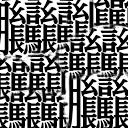

  0%|          | 0/100 [00:00<?, ?it/s]

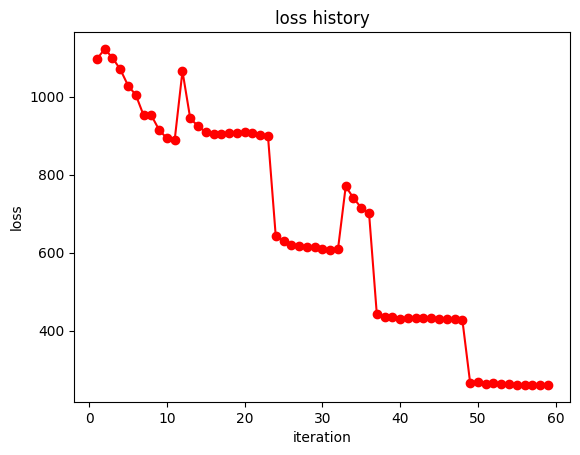

In [9]:
#@markdown **セルを実行して，textureの元画像をアップロードすると処理が始まる**
#@markdown  \\
#@markdown 処理の途中の画像の変化やプログレスバーも表示する
#@markdown  \\
#@markdown  デモの画像は
#@markdown https://hotekagi.github.io/gc_assignment/I3_TextureSynthesis/sample_images/biang.png
#@markdown
#@markdown これは[ビャンビャン麺のwikipedia](https://ja.wikipedia.org/wiki/ビャンビャン麺)にある漢字の画像を92px * 92pxにしたもの \\
#@markdown
#@markdown 1辺の長さが4の倍数の画像を入力すること


from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image
from tqdm.notebook import tqdm

from google.colab import files
uploaded = files.upload()

### variables
#@markdown **パラメータを設定する**

#@markdown 生成する画像の1辺のサイズ
target_width = 128 #@param {type: "integer"}
#@markdown 最大反復回数
max_iter = 100 #@param {type: "integer"}
#@markdown　実行時にloss, levelの詳細を表示
debug = False #@param {type: "boolean"}

if len(list(uploaded.keys())) == 0:
    raise Exception("キャンセルしました")

texture = cv2.imread(list(uploaded.keys())[0])
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)

target = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
img_display = display(Image.fromarray(target), display_id=True)


### items for this algorithm
### init level 0
current_texture = cv2.resize(texture, (texture.shape[0] // 4, texture.shape[1] // 4))
current_target = cv2.resize(target, (target_width // 4, target_width // 4))
neighbor_width = 8

### util functions
def init_anchors(target_width, neighbor_width, current_texture):
    indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
    x, y = np.meshgrid(indices, indices)
    target_anchors = np.column_stack((y.ravel(), x.ravel()))

    texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
    texture_anchors[:, 0] = np.random.randint(
        0, current_texture.shape[0] - neighbor_width, size=len(target_anchors)
    )
    texture_anchors[:, 1] = np.random.randint(
        0, current_texture.shape[1] - neighbor_width, size=len(target_anchors)
    )
    return target_anchors, texture_anchors

def update_anchors(target_width, neighbor_width, current_texture):
    indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
    x, y = np.meshgrid(indices, indices)
    target_anchors = np.column_stack((y.ravel(), x.ravel()))

    texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
    for i, target_anchor in enumerate(target_anchors):
        y, x = target_anchor
        result = cv2.matchTemplate(
            current_texture,
            current_target[y : y + neighbor_width, x : x + neighbor_width, :],
            method=cv2.TM_SQDIFF,
        )
        _, _, min_loc, _ = cv2.minMaxLoc(result)
        texture_anchors[i] = np.array([min_loc[1], min_loc[0]])

    return target_anchors, texture_anchors

target_anchors, texture_anchors = init_anchors(
    current_target.shape[0], neighbor_width, current_texture
)

loss_history = []
level = 0
is_transiting = False


for iter in tqdm(range(1, max_iter+1)):
    ### scheduling for neighbor_width and resolution
    if level == 1 and is_transiting:
        transiting = False
        current_texture = cv2.resize(
            texture, (texture.shape[0] // 2, texture.shape[1] // 2)
        )
        current_target = cv2.resize(current_target, (target_width // 2, target_width // 2))
        neighbor_width = 16
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if level == 2 and is_transiting:
        neighbor_width = 8
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if level == 3 and is_transiting:
        current_texture = texture
        current_target = cv2.resize(current_target, (target_width, target_width))
        neighbor_width = 32
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if level == 4 and is_transiting:
        neighbor_width = 16
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if level == 5 and is_transiting:
        neighbor_width = 8
        target_anchors, texture_anchors = update_anchors(
            current_target.shape[0], neighbor_width, current_texture
        )
    if level == 6:
        break

    # update target to argmin(E(target, texture))
    ref_for_pixel = [
        [] for _ in range(current_target.shape[0] * current_target.shape[1])
    ]

    for target_anchor, texture_anchor in zip(target_anchors, texture_anchors):
        y, x = target_anchor
        yy, xx = texture_anchor
        for i in range(neighbor_width):
            for j in range(neighbor_width):
                ref_for_pixel[(y + i) * current_target.shape[1] + (x + j)].append(
                    current_texture[yy + i, xx + j]
                )

    loss = 0
    for y in range(current_target.shape[0]):
        for x in range(current_target.shape[1]):
            current_target[y, x] = np.mean(
                ref_for_pixel[y * current_target.shape[1] + x], axis=0
            )
            loss += np.sum(
                (ref_for_pixel[y * current_target.shape[1] + x] - current_target[y, x]) ** 2
            )

    mse = loss / (current_target.shape[0] * current_target.shape[1]) / 3
    if debug:
        print(f"iter {iter}: loss:{mse}")
    loss_history.append(mse)
    img_display.update(
        Image.fromarray(current_target)
    )

    # update texture reference points
    texture_anchors_prev = texture_anchors.copy()
    target_anchors, texture_anchors = update_anchors(
        current_target.shape[0], neighbor_width, current_texture
    )

    if np.all(texture_anchors == texture_anchors_prev) or mse in loss_history[-3:-1]:
        level += 1
        is_transiting = True
        if debug:
            print(f"transiting!!! level {level}")


plt.plot(range(1, len(loss_history) + 1), loss_history, "ro-")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("loss history")
plt.show()

now = datetime.now()
now = now.strftime("%Y%m%d%H%M%S")
Image.fromarray(current_target).save(f"synthesized_mul_texture_{now}.png")


```
The error is found to converge to a much smaller value than in Algorithm 1.  
Using the same image, similar results can be obtained with both algorithms.  
(Feel free to try it out in this demonstration.)

In downsampling images, the error can be reduced because of the lower number of pixels.  
However, when upsampling, the generated image increases its pixel count, resulting in a blurry image.   
On the other hand, the reference texture can utilize finer details, leading to an increase in error.  
Nevertheless, overall, the error converges to a low value.
```